## Testing out the `bracket_builder` package I was working on last year

In [13]:
import os
import sys
import numpy as np
import pandas as pd
import bracket_builder.draw as bb
import bracket_builder.calculate as brac_calc

### Test out drawing a 32 team bracket... oh wait, it's 16 this year and I haven't done that

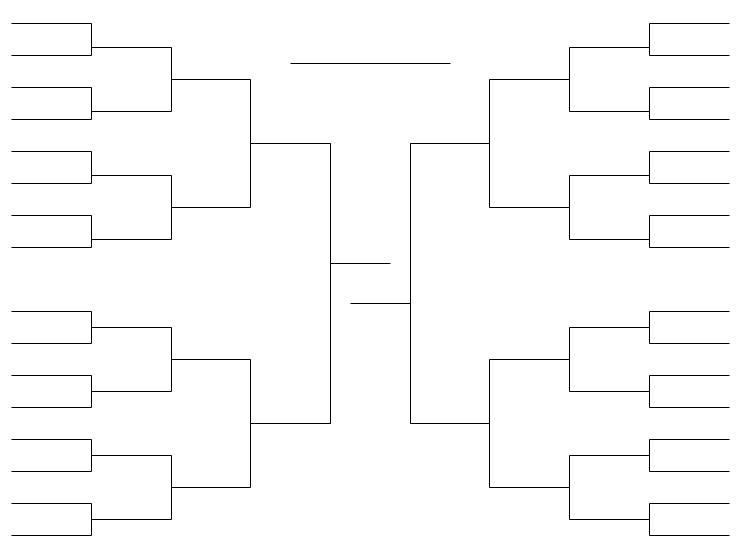

In [3]:
b = bb.Bracket(32)
b.draw_bracket()

### Adding names

In [4]:
os.chdir("../data/men/")

In [5]:
## Get past tournament data to test with
seeds = pd.read_csv("NIT-Seeds.csv")
nit_slots = pd.read_csv("NIT-Slots.csv")

In [6]:
### Limit to current season
seeds_2021 = seeds[seeds['Season'] == 2021].copy()

## Proper ordering for seeds within each region in the 1st round
seed_order = pd.DataFrame({'seed_num': [1, 4, 3, 2],
                           'seed_ord': [1, 2, 3, 4]})
seeds_2021 = seeds_2021.merge(seed_order)

## Sort it properly and check it out
seeds_2021 = seeds_2021.sort_values(['region', 'seed_ord'])
seeds_2021.head(16)

,Season,TeamID,TeamName,seed_num,region,Seed,seed_ord
0,2021,1161,Colorado St,1,W,W1,1
4,2021,1138,Buffalo,4,W,W4,2
12,2021,1301,NC State,3,W,W3,3
8,2021,1172,Davidson,2,W,W2,4
1,2021,1272,Memphis,1,X,X1,1
5,2021,1173,Dayton,4,X,X4,2
13,2021,1374,SMU,3,X,X3,3
9,2021,1129,Boise St,2,X,X2,4
2,2021,1387,St Louis,1,Y,Y1,1
6,2021,1280,Mississippi St,4,Y,Y4,2


In [7]:
## Get submission for round 2
subs_path = "subs/nit_probs_2021-03-19.csv"
sub = pd.read_csv(subs_path)
sub = sub[['ID', 'Pred']]
sub['Season'] = sub['ID'].apply(lambda x: x.split('_')[0]).astype(int)
sub['TeamID_1']  = sub['ID'].apply(lambda x: x.split('_')[1]).astype(int)
sub['TeamID_2']  = sub['ID'].apply(lambda x: x.split('_')[2]).astype(int)

## Merge team 1 name
teams = seeds.rename(columns={'TeamName': 'TeamName_1',
                              'TeamID': 'TeamID_1'})
teams = teams[['TeamName_1', 'TeamID_1']]
sub = sub.merge(teams, on='TeamID_1', how='left')

## Merge team 2 name
teams = teams.rename(columns={'TeamName_1': 'TeamName_2',
                              'TeamID_1': 'TeamID_2'})
sub = sub.merge(teams, on='TeamID_2', how='left')
sub = sub.drop_duplicates()

sub.head()

,ID,Pred,Season,TeamID_1,TeamID_2,TeamName_1,TeamName_2
0,2021_1138_1161,0.453546,2021,1138,1161,Buffalo,Colorado St
2,2021_1129_1161,0.502902,2021,1129,1161,Boise St,Colorado St
4,2021_1138_1172,0.460111,2021,1138,1172,Buffalo,Davidson
6,2021_1161_1172,0.490721,2021,1161,1172,Colorado St,Davidson
8,2021_1129_1172,0.509516,2021,1129,1172,Boise St,Davidson


In [8]:
## Merge in seeds to submission
tourney_seeds_df = seeds.rename(columns = {'TeamID': 'TeamID_1', 'Seed': 'Seed_1'})
sub = sub.merge(tourney_seeds_df, on = ['TeamID_1', 'Season'])
tourney_seeds_df = tourney_seeds_df.rename(columns = {'TeamID_1': 'TeamID_2', 'Seed_1': 'Seed_2'})
sub = sub.merge(tourney_seeds_df, on = ['TeamID_2', 'Season'])

## Add a field to slots with the possible teams that could reach that round
nit_slots['round'] = nit_slots['Slot'].apply(lambda x: int(x[1]) if x.startswith('R')
                                                           else 0)
nit_slots['possible_teams'] = nit_slots.apply(lambda x: 
                                    brac_calc.exhaust_possible_seeds(nit_slots,
                                                           [x['StrongSeed'],
                                                            x['WeakSeed']]), axis = 1)

## Add a column to tourney results with the round that the 2 teams meet
sub['round'] = sub.apply(lambda x: brac_calc.get_round_met(nit_slots, x['Seed_1'], x['Seed_2']),
                                         axis = 1)
 

In [11]:
def find_round_prob(sub_df, probs_df, team_id, rnd):
    """
    Get the probability that a given team reaches a round
    
    Parameters
    ----------
    sub_df : DataFrame
        Submission dataframe with round added.
    team_name : str
        Name of team.
    rnd : int
        Round of interest to get probability for.
    
    Returns
    -------
    rnd_prob : float
        Probability that a team reaches the round.
    """
    ## Get all possible matchups for the team in prior round
    team_round_preds = sub_df[((sub_df['TeamID_1'] == team_id) | 
                               (sub_df['TeamID_2'] == team_id)) &
                               (sub_df['round'] == rnd-1)].copy()

    ## Defining a dict of column names corresponding to the round
    rd_cols = {1: 'Round1',
               2: 'Elite8',
               3: 'Final4',
               4: 'Final',
               5: 'Champ'}

    if len(team_round_preds) == 1:
        ## only 1 matchup to worry about, just get the corresponding prob for that team
        if team_id in list(team_round_preds['TeamID_1']):
            rnd_prob = float(team_round_preds['Pred'])
        else:
            rnd_prob = 1-float(team_round_preds['Pred'])
        if rnd > 0:
            team_prob_reaching = float(probs_df[probs_df['TeamID'] == team_id][rd_cols[rnd-1]])
            rnd_prob = rnd_prob*team_prob_reaching
    elif len(team_round_preds) == 0:
        ## If they didn't have any games in the prior round, 
        ### probability is 1 (applies to non-play-in teams making round 1)
        rnd_prob = 1
    else:
        ## Using a json-like structure containing probabilities that an opposing team would make that round
        ### and probability that the team of interest would beat that team
        conditional_team_probs = {}

        ## Keys for the dict: possible teams
        possible_teams = list((set(team_round_preds['TeamID_1']) | 
                               set(team_round_preds['TeamID_2'])) - set([team_id]))

        ## Used for lookup in value 1 below
        prob_reaching_df = (probs_df[probs_df['TeamID'].isin(possible_teams)]
                                     [['TeamID', rd_cols[rnd-1]]]
                                     .rename(columns = {rd_cols[rnd-1]: 'prob_reaching_rd'}))

        for t in possible_teams:
            within_dict = {}
            ## Value 1 (conditional part): chances that the opposing teams make the round
            within_dict['prob_reaching'] = float(prob_reaching_df[prob_reaching_df['TeamID'] == t]['prob_reaching_rd'])            

            ## Value 2: win probability for the team of interest over the possible opposing team
            if team_id < t:
                win_prob = float(team_round_preds[team_round_preds['TeamID_2'] == t]['Pred'])
            else:
                win_prob = 1-float(team_round_preds[team_round_preds['TeamID_1'] == t]['Pred'])
            within_dict['win_prob'] = win_prob
            conditional_team_probs[t] = within_dict

        ### Get probability for the team for the prior round
        team_prob_reaching = float(probs_df[probs_df['TeamID'] == team_id][rd_cols[rnd-1]])

        ### Calculate probability of making to the round of interest
        rnd_games_probs = (np.sum([(t['prob_reaching']*t['win_prob'])
                             for t in conditional_team_probs.values()]))

        rnd_prob = rnd_games_probs*team_prob_reaching
    
    return rnd_prob


In [14]:
## For each team, go through each round and calculate the prob. that they'll be in the next round
##  based on the submission.
team_names = list(set(sub['TeamName_1']) | set(sub['TeamName_2']))
team_names.sort()
probs_df = pd.DataFrame({'TeamName': team_names})
probs_df = probs_df.merge(seeds[['TeamName', 'TeamID']], on = 'TeamName')
probs_df['Round1'] = 1

## Fill in probabilities of reaching each round, round by round
probs_df['Elite8']  = probs_df['TeamID'].apply(lambda x: find_round_prob(sub, probs_df, x, 2))
probs_df['Final4']  = probs_df['TeamID'].apply(lambda x: find_round_prob(sub, probs_df, x, 3))
probs_df['Final']   = probs_df['TeamID'].apply(lambda x: find_round_prob(sub, probs_df, x, 4))
probs_df['Champ']   = probs_df['TeamID'].apply(lambda x: find_round_prob(sub, probs_df, x, 5))

probs_df = probs_df.drop(columns = ['Round1'])
probs_df.sort_values('Champ', ascending = False).head(20)

,TeamName,TeamID,Elite8,Final4,Final,Champ
6,Memphis,1272,0.690131,0.407362,0.254701,0.149536
12,St Louis,1387,0.642924,0.373424,0.221858,0.125295
7,Mississippi,1279,0.661481,0.422265,0.226835,0.125155
11,SMU,1374,0.520218,0.251202,0.137379,0.070517
10,Richmond,1350,0.519461,0.248570,0.132356,0.065860
9,NC State,1301,0.522428,0.276722,0.127662,0.062083
2,Colorado St,1161,0.546454,0.266289,0.118540,0.056311
0,Boise St,1129,0.479782,0.214927,0.109811,0.054190
14,Toledo,1405,0.480539,0.222907,0.112676,0.052626
3,Davidson,1172,0.477572,0.249847,0.109619,0.051362


In [15]:
probs_df.to_csv("viz-files/nit-round-by-round-2021-03-19.csv", index = False)


In [25]:
## Incorporating actual results.
round_by_round_df = pd.read_csv("viz-files/nit-round-by-round-e8-2021-03-19.csv")
round_by_round_df['Final4']  = round_by_round_df['TeamID'].apply(lambda x: find_round_prob(sub, 
                                                                                           round_by_round_df, x, 3))
round_by_round_df['Final']   = round_by_round_df['TeamID'].apply(lambda x: find_round_prob(sub,
                                                                                           round_by_round_df, x, 4))
round_by_round_df['Champ']   = round_by_round_df['TeamID'].apply(lambda x: find_round_prob(sub,
                                                                                           round_by_round_df, x, 5))

round_by_round_df = round_by_round_df[round_by_round_df['Elite8'] > 0].drop(columns = ['TeamID'
                                                                                       #, 'Elite8'
                                                                                      ])
round_by_round_df.sort_values('Champ', ascending = False).head(20)

,TeamName,Elite8,Final4,Final,Champ
6,Memphis,0.690131,0.419896,0.256405,0.158372
10,Richmond,1.000000,0.478515,0.292930,0.146310
12,St Louis,0.642924,0.372348,0.249793,0.140475
9,NC State,1.000000,0.515823,0.242296,0.124064
0,Boise St,1.000000,0.447967,0.225299,0.117538
2,Colorado St,1.000000,0.484177,0.219329,0.110389
5,Louisiana Tech,1.000000,0.528000,0.201202,0.079361
15,WKU,1.000000,0.472000,0.174532,0.064177
8,Mississippi St,0.357076,0.149137,0.081544,0.034720
4,Dayton,0.309869,0.132137,0.056671,0.024593


In [26]:
round_by_round_df.to_csv("viz-files/nit-round-by-round-2021-03-20.csv", index = False)

In [ ]:
sub_df = sub

In [ ]:
## Get all possible matchups for the team in prior round
team_round_preds = sub_df[((sub_df['TeamID_1'] == team_id) | 
                           (sub_df['TeamID_2'] == team_id)) &
                           (sub_df['round'] == rnd-1)].copy()

## Defining a dict of column names corresponding to the round
rd_cols = {1: 'Round1',
           2: 'Elite8',
           3: 'Final4',
           4: 'Final',
           5: 'Champ'}

if len(team_round_preds) == 1:
    ## only 1 matchup to worry about, just get the corresponding prob for that team
    if team_id in list(team_round_preds['TeamID_1']):
        rnd_prob = float(team_round_preds['Pred'])
    else:
        rnd_prob = 1-float(team_round_preds['Pred'])
    if rnd > 0:
        team_prob_reaching = float(probs_df[probs_df['TeamID'] == team_id][rd_cols[rnd-1]])
        rnd_prob = rnd_prob*team_prob_reaching
elif len(team_round_preds) == 0:
    ## If they didn't have any games in the prior round, 
    ### probability is 1 (applies to non-play-in teams making round 1)
    rnd_prob = 1
else:
    ## Using a json-like structure containing probabilities that an opposing team would make that round
    ### and probability that the team of interest would beat that team
    conditional_team_probs = {}
    
    ## Keys for the dict: possible teams
    possible_teams = list((set(team_round_preds['TeamID_1']) | 
                           set(team_round_preds['TeamID_2'])) - set([team_id]))
    
    ## Used for lookup in value 1 below
    prob_reaching_df = (probs_df[probs_df['TeamID'].isin(possible_teams)]
                                 [['TeamID', rd_cols[rnd-1]]]
                                 .rename(columns = {rd_cols[rnd-1]: 'prob_reaching_rd'}))
    
    for t in possible_teams:
        within_dict = {}
        ## Value 1 (conditional part): chances that the opposing teams make the round
        within_dict['prob_reaching'] = float(prob_reaching_df[prob_reaching_df['TeamID'] == t]['prob_reaching_rd'])            
        
        ## Value 2: win probability for the team of interest over the possible opposing team
        if team_id < t:
            win_prob = float(team_round_preds[team_round_preds['TeamID_2'] == t]['Pred'])
        else:
            win_prob = 1-float(team_round_preds[team_round_preds['TeamID_1'] == t]['Pred'])
        within_dict['win_prob'] = win_prob
        conditional_team_probs[t] = within_dict
    
    ### Get probability for the team for the prior round
    team_prob_reaching = float(probs_df[probs_df['TeamID'] == team_id][rd_cols[rnd-1]])
    
    ### Calculate probability of making to the round of interest
    rnd_games_probs = (np.sum([(t['prob_reaching']*t['win_prob'])
                         for t in conditional_team_probs.values()]))
    
    rnd_prob = rnd_games_probs*team_prob_reaching


In [ ]:
team_round_preds[team_round_preds['TeamID_2'] == t]['Pred']

In [ ]:
team_round_preds.ID

In [ ]:
t

In [ ]:
seeds[seeds['TeamID'] == team_id]

In [ ]:
rnd_prob

In [ ]:
round_by_round_probs_df.to_csv("viz-files/round-by-round-probs-untrimmed-2021-03-16.csv", index = False)

In [ ]:
## Submission with Michigan and Gonzaga manually scaled back some
subs_path = "subs/submission_probs_untrimmed_2021-03-17.csv"
round_by_round_probs_df = brac_calc.compute_conditional_probs(subs_path, league = 'men')
round_by_round_probs_df.to_csv("viz-files/round-by-round-probs-untrimmed-2021-03-17.csv", index = False)

round_by_round_probs_df.sort_values('Champ', ascending = False).head(20)

### Plot what it predicts!


In [ ]:
### Label team names (note: had to switch 'Z' and 'Y' region labels.)
b_2 = bb.Bracket(n_teams = 64, team_names = list(seeds_2021['TeamName']))
b_2.draw_bracket()
b_2.label_teams()

## To-Do

  1. Fix up the `label_winners()` function and/or get a pipeline to easily get winners in required order
  2. Complete the `draw_weighted_lines()` function to draw lines in the team's colors.
  3. Get a pipeline in `calculate` going to `compute_conditional_probs()` in a way that works seamlessly with weighted lines.